## 要验证一下模型输出的正确性

In [1]:
import h5py
import torch
from torch.utils import data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""

    def __init__(self, list_IDs, labels, path=None):
        """Initialization"""
        self.labels = labels
        self.list_IDs = list_IDs
        self.file_path = path
        self.dataset = None

    def __len__(self):
        """Denotes the total number of samples"""
        return len(self.list_IDs)

    def __getitem__(self, index):
        """Generates one sample of data"""
        # Select sample
        ID = self.list_IDs[index]
        if self.dataset is None:
            self.dataset = h5py.File(self.file_path, 'r')
#         print(ID)
        X = self.dataset[ID][()]
        X = torch.from_numpy(X)
        # [frames, bins]

        y = self.labels[ID]

        return X, y

In [3]:
device = 'cpu'
fold='4'
configs = {'batch_size': 64,
           'shuffle': False,
           'num_workers': 1}

In [8]:
def get_generator(emo):
    path_to_features='./best_model_outputs/{emo}.hdf5'.format(emo=emo)

    labels = {}
    dict_emo = {'a': 0, 'h': 1, 'n': 2, 's': 3}

    with open('total.txt', 'r') as f:
        total = f.read().split('\n')
    testData = []
    for item in total:
        labels[item] = dict_emo[item[4]]
        if 'impro' in item and item.startswith('0{fold}'.format(fold=fold)):  # e.g. 04F
            testData.append(item)

    validation_set = Dataset(testData, labels, path=path_to_features)
    print(len(validation_set))
    validation_generator = data.DataLoader(validation_set, **configs)
    return validation_generator

In [5]:
def get_pred_and_label(validation_generator):
    y_pred = torch.LongTensor().to(device)
    y_true = torch.LongTensor().to(device)

    for local_batch, local_labels in validation_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(
            device)

        outputs = local_batch
        # print('testLoss: ', loss)
        _, predict = torch.max(outputs, 1)
        y_pred = torch.cat([y_pred, predict], 0)
        y_true = torch.cat([y_true, local_labels], 0)
    return y_pred, y_true

In [6]:
def get_metrics(y_pred, y_true):
    confusion = confusion_matrix(y_true, y_pred).astype('float16').T
    wa = precision_score(y_true, y_pred, average='micro')
    ua = recall_score(y_true, y_pred, average='macro')
    test_emotion_recalls = confusion.diagonal() / confusion.sum(0)
    return ua, wa, test_emotion_recalls

In [9]:
for emo in ['ang', 'hap', 'neu', 'sad']:
    validation_generator = get_generator(emo)
    y_pred, y_true = get_pred_and_label(validation_generator)
    ua, wa, test_emotion_recalls = get_metrics(y_pred, y_true)
    print('emo: ', emo)
    print('ua, ', ua, 'wa, ', wa)
    print('emotion_recall, ', test_emotion_recalls)

534
emo:  ang
ua,  0.6875021051745189 wa,  0.700374531835206
emotion_recall,  [0.5356 0.764  0.6724 0.778 ]
534
emo:  hap
ua,  0.6714912003705107 wa,  0.6928838951310862
emotion_recall,  [0.3691 0.882  0.546  0.8887]
534
emo:  neu
ua,  0.6677224116879289 wa,  0.6947565543071161
emotion_recall,  [0.2856 0.6973 0.799  0.8887]
534
emo:  sad
ua,  0.64743075145374 wa,  0.6760299625468165
emotion_recall,  [0.1904 0.759  0.6895 0.9507]


### 上面单元格的输出：  
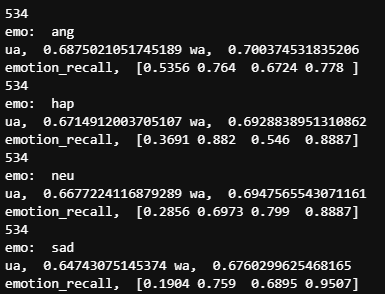  
### 验证完成，与原始一致。  
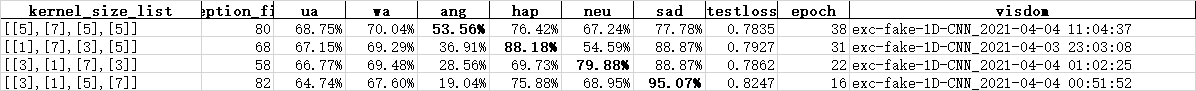